# Notebook goal: 

* Train a baseline Linear Regression, evaluate it, try one regularized improvement (Ridge), compare, save the best model.

In [ ]:
import os
os.chdir("Spotify-Popularity-Predictor")
%pwd


'c:\\Users\\ecole\\CoreML-Ayush\\Spotify-Popularity-Predictor'

In [ ]:
import json, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams["figure.figsize"] = (20, 8)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error


In [51]:
from src.utils.helper import save_pickle
from src.utils.metrics_logger import save_metrics

In [4]:
from src.utils.helper import get_config

config = get_config()

Initialized logger...


In [5]:
df = pd.read_csv(config["data"]["processed"]["clean"])
X = df.drop(columns=config["target"])
y = df[config["target"]]

print(f"X shape: {X.shape}")
print(f"X features: {X.columns}")


X shape: (4648, 26)
X features: Index(['danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'valence', 'loudness_scaled', 'tempo_scaled',
       'liveness', 'duration_ms_log_scaled', 'mode', 'song_age_scaled',
       'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0',
       'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0',
       'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0'],
      dtype='object')


In [6]:
y.head()

0    23
1    53
2    55
3    64
4    62
Name: track_popularity, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"x train shape: {X_train.shape}")
print(f"x test shape: {X_test.shape}")
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

In [8]:

print(f"x train shape: {X_train.shape}")
print(f"x test shape: {X_test.shape}")
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

x train shape: (3718, 26)
x test shape: (930, 26)
y train shape: (3718,)
y test shape: (930,)


In [9]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [15]:
# Check which feature has more predictive power

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)
coef_df


,Feature,Coefficient
11,song_age_scaled,28.544012
0,danceability,8.695379
22,key_11.0,3.119780
21,key_10.0,2.858217
16,key_5.0,2.814937
12,key_1.0,2.642558
19,key_8.0,2.162972
6,loudness_scaled,1.990637
14,key_3.0,1.928445
17,key_6.0,0.993014


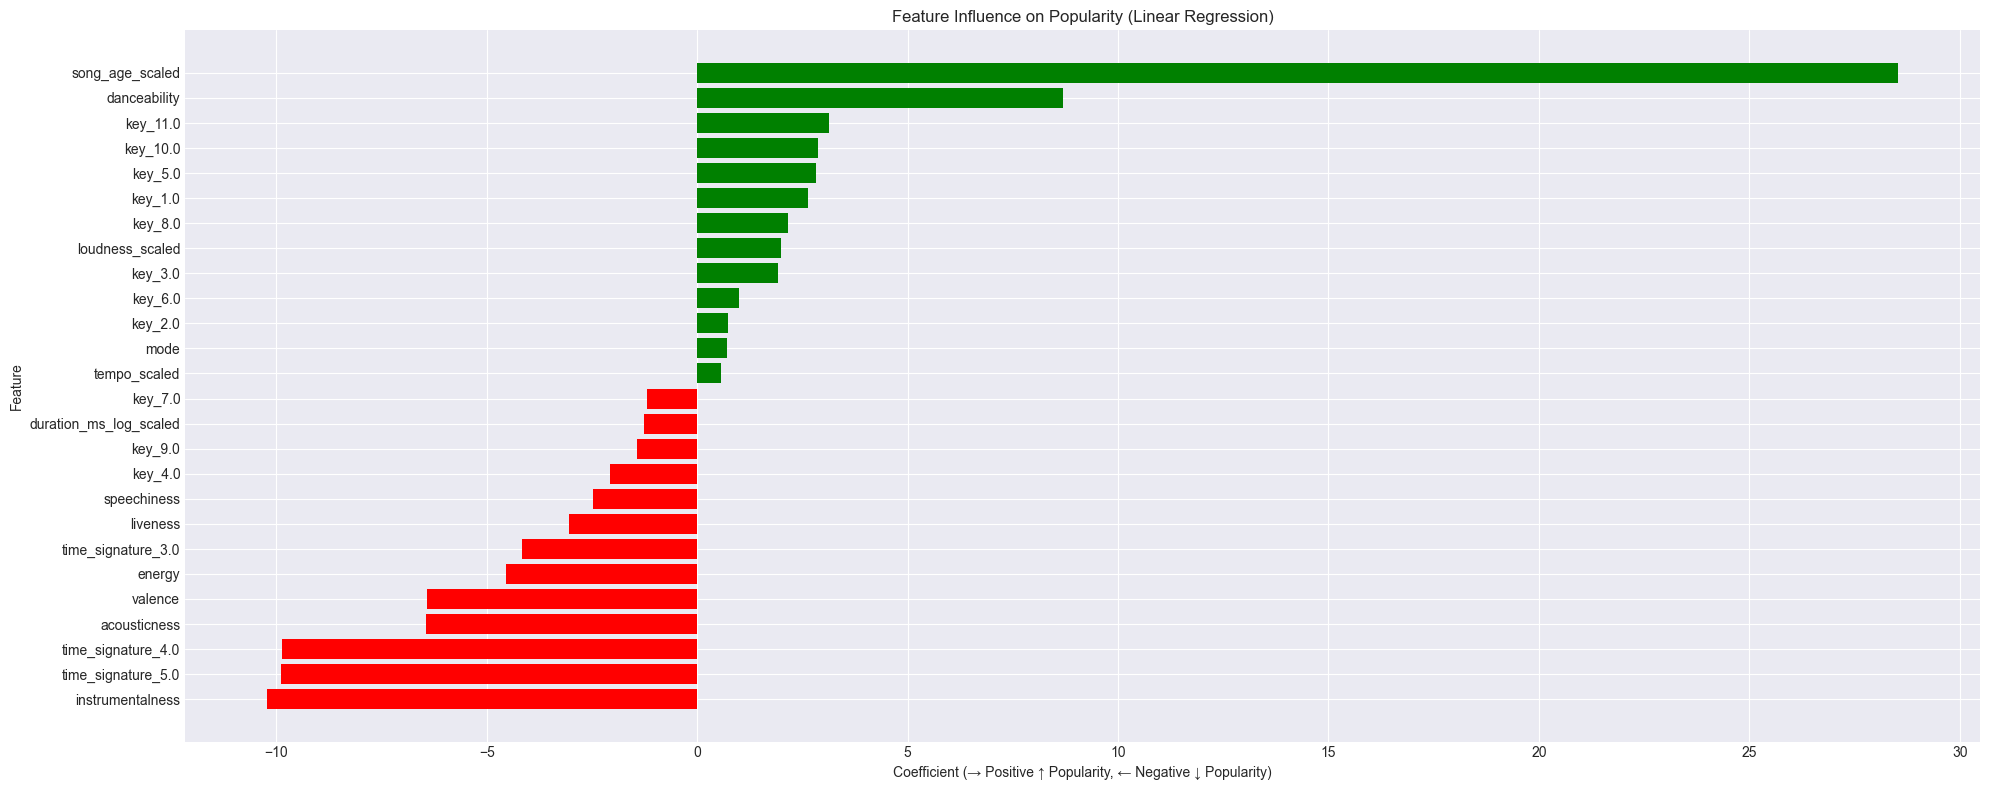

In [22]:
coef_df_sorted = coef_df.sort_values("Coefficient", ascending=True)
colors = coef_df_sorted["Coefficient"].apply(lambda x: 'green' if x > 0 else 'red')

plt.barh(coef_df_sorted["Feature"], coef_df_sorted["Coefficient"], color=colors)
plt.title("Feature Influence on Popularity (Linear Regression)")
plt.xlabel("Coefficient (→ Positive ↑ Popularity, ← Negative ↓ Popularity)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Insight:

* Popularity increases with song age, danceability, and loudness.

* Popularity decreases with instrumentalness, acousticness, and rare time signatures.

In [23]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Evaluate Model

In [24]:
metrics = {
    "Dataset": ["Train", "Test"],
    "R² Score": [
        r2_score(y_train, y_pred_train),
        r2_score(y_test, y_pred_test)
    ],
    "MAE": [
        mean_absolute_error(y_train, y_pred_train),
        mean_absolute_error(y_test, y_pred_test)
    ],
    "RMSE": [
        root_mean_squared_error(y_train, y_pred_train),
        root_mean_squared_error(y_test, y_pred_test)
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.round(4)
metrics_df

,Dataset,R² Score,MAE,RMSE
0,Train,0.1297,15.0690,18.5854
1,Test,0.0975,15.0698,18.5340


### 💡 **Interpretation**

1. **Low R² on both train (0.13) and test (0.10)**
   * The model is **not overfitting**, it’s just **underfitting (too simple)**
   * but it’s also **not explaining much of the variance** in popularity.
   It means that only ~10% of the variation in track popularity can be explained by our current features.

2. **MAE ≈ 15 popularity points**
   * On average, the model’s predictions are off by around 15 points on the 0–100 popularity scale. That’s quite large.

3. **RMSE ≈ 18**
   * Errors are spread around ±18 points, confirms the model struggles to capture complex patterns.

4. **Conclusion:**

   * The linear model captures only **weak linear relationships** between audio features and popularity.
   * This suggests that **popularity may depend on nonlinear or external factors** (e.g., marketing, artist fame, playlist placements, social trends).



In [ ]:
# Convert metrics_df to a simpler dict for saving

# Save as JSON
metrics_to_save = {
    f"{col.lower()}_{row.lower()}": metrics_df.loc[metrics_df["Dataset"] == row, col].values[0]
    for col in ["R² Score", "MAE", "RMSE"]
    for row in ["Train", "Test"]
}


# ✅ Ensure the folder exists
os.makedirs(os.path.dirname(config["artifacts"]["metrics"]), exist_ok=True)

# ✅ Save the metrics dictionary
with open(config["artifacts"]["metrics"], "w") as f:
    json.dump({"LinearRegression": metrics_to_save}, f, indent=4)

print(f"✅ Metrics saved successfully to: {os.path.abspath(config['artifacts']['metrics'])}")

# save_metrics("LinearRegression", metrics_to_save, config["artifacts"]["metrics"])

✅ Metrics saved successfully to: c:\Users\ecole\CoreML-Ayush\Spotify-Popularity-Predictor\artifacts\models\metrics.json


## Quick diagnostics

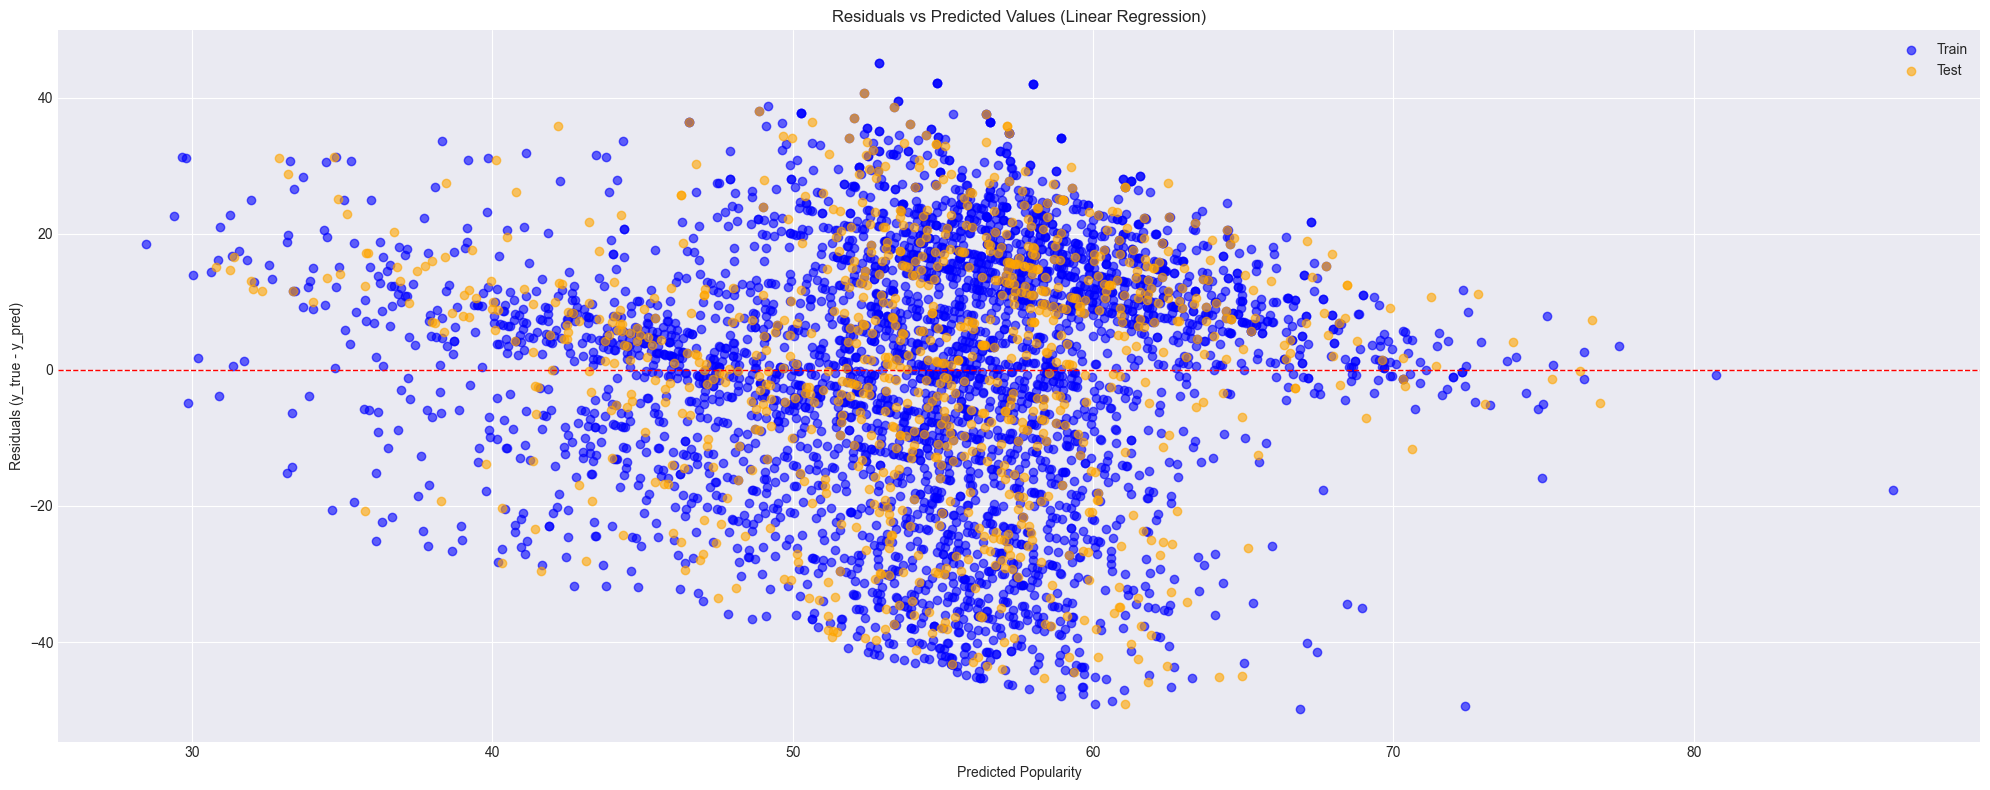

In [ ]:

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# ✅ Combine for a single “overall” residual plot
y_pred_all = np.concatenate([y_pred_train, y_pred_test])
residuals_all = np.concatenate([residuals_train, residuals_test])
split_labels = (["Train"] * len(y_pred_train)) + (["Test"] * len(y_pred_test))

residuals_df = pd.DataFrame({
    "Predicted": y_pred_all,
    "Residual": residuals_all,
    "Split": split_labels
})

# ✅ Plot
for split, color in [("Train", "blue"), ("Test", "orange")]:
    subset = residuals_df[residuals_df["Split"] == split]
    plt.scatter(subset["Predicted"], subset["Residual"], alpha=0.6, label=split, color=color)

# ✅ Add horizontal line at 0 (perfect prediction)
plt.axhline(y=0, color="red", linestyle="--", linewidth=1)

plt.title("Residuals vs Predicted Values (Linear Regression)")
plt.xlabel("Predicted Popularity")
plt.ylabel("Residuals (y_true - y_pred)")
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion:

Your linear regression is doing okay but clearly missing some structure in the data, the residuals aren’t random enough. 

The cone shape and curvature suggest nonlinear patterns. 

A nonlinear model would likely perform better.